# A Particle Neural Network Toy Model for Jet Classification

Below are the import statements, as well as some self-built code modulas.

In [1]:
from MakeData import MakeData
from ParticleNet import ParticleNet
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from mpl_toolkits import mplot3d
import neural_structured_learning as nsl
from collections import defaultdict
from Adversary import Adversary

The user decides the constant momentum used for this simulation for all particles, as well as the size of the training and testing data sets.  The actual size of the test and training data sets is doubled as these numbers are for each distribution. 

In [2]:
p = 100
Ntrain = 1000000
Ntest = 1000000
Epochs = 10

Here, I create the simulation data of a million particles per distribution for the training and testing data sets.

In [3]:
train,train_vals = MakeData(p,Ntrain)
test,test_vals = MakeData(p,Ntest)

Below is a 3D plot of the momentum of each particle.  Notice how all particles have constant total momentum but random direction, resulting in the data points filling out the surface of a sphere.

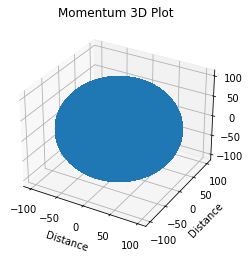

In [4]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(train[:,0], train[:,1], train[:,2]);
plt.title('Momentum 3D Plot')
plt.xlabel('Distance')
plt.ylabel('Distance')
fig.savefig('Momentum.png')

Below is a plot of the mass distributions for the training data set.  One expodential, one guassian.

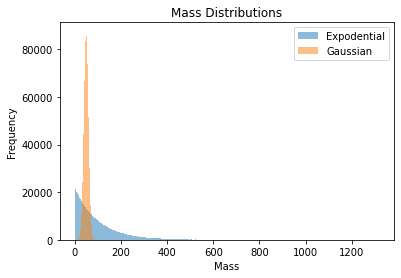

In [5]:
fig = plt.figure()
n,bins,weights = plt.hist(train[train_vals==0,3], bins = 'auto', alpha = 0.5, label = 'Expodential')
plt.hist(train[train_vals==1,3], bins = bins, alpha = 0.5, label = 'Gaussian')
plt.xlabel('Mass')
plt.ylabel('Frequency')
plt.title('Mass Distributions')
plt.legend()
fig.savefig('Mass.png')

Here is a plot of Tau, the measure of N-subjettiness which is different for each mass distribution, and represented by a expodential distribution.

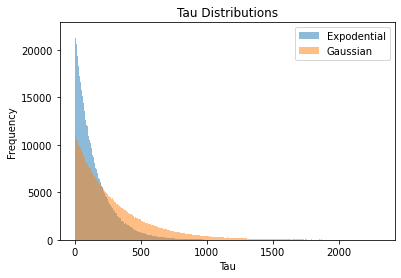

In [6]:
fig = plt.figure()
n,bins,weights = plt.hist(train[train_vals==0,4], bins = 'auto', alpha = 0.5, label = 'Expodential')
plt.hist(train[train_vals==1,4], bins = bins, alpha = 0.5,label = 'Gaussian')
plt.title('Tau Distributions')
plt.xlabel('Tau')
plt.ylabel('Frequency')
plt.legend()
fig.savefig('Tau.png')

Here, I show that the simulation data is shuffled before being fed into the neural networks.  This vector is of the true classifications of each particle, where 0 represents an expodential distribution and 1 a gaussian distribution.

In [7]:
print(test_vals[0:20])

[1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0.]


This line of code runs an ordinary neural network model.  The predictions for the test data set are returned.  These predictions are the probability guesses of the neural network for the test data set.  For each particle, the neural network will return a probability for each classification, two numbers in this case, one for the probability that particle is a 0, and another the probability this particle is a 1, representing expodential vs gaussian respectivly.

In [8]:
predictions = ParticleNet(train,train_vals,test,Epochs)

Epoch 1/10
62500/62500 [==============================] - 34s 533us/step - loss: 0.4057 - accuracy: 0.8305
Epoch 2/10
62500/62500 [==============================] - 36s 573us/step - loss: 0.3354 - accuracy: 0.8547
Epoch 3/10
62500/62500 [==============================] - 38s 615us/step - loss: 0.3308 - accuracy: 0.8567
Epoch 4/10
62500/62500 [==============================] - 36s 578us/step - loss: 0.3284 - accuracy: 0.8578
Epoch 5/10
62500/62500 [==============================] - 36s 583us/step - loss: 0.3292 - accuracy: 0.8571
Epoch 6/10
62500/62500 [==============================] - 36s 579us/step - loss: 0.3291 - accuracy: 0.8573
Epoch 7/10
62500/62500 [==============================] - 36s 583us/step - loss: 0.3287 - accuracy: 0.8573
Epoch 8/10
62500/62500 [==============================] - 36s 580us/step - loss: 0.3287 - accuracy: 0.8573
Epoch 9/10
62500/62500 [==============================] - 36s 577us/step - loss: 0.3285 - accuracy: 0.8575
Epoch 10/10
62500/62500 [============

Here are the results of this ordinary neural network.  Accuracy is between 74% and 82% and the expodential data particles had a higher chance of being correctly classified than the guassian particles.

In [9]:
FalseExps = sum(predictions[np.where(test_vals == 0)])/Ntest*100
print("The model, on average, thought a Expodential distribution to be just that at " + str(FalseExps[0]) + " percent.")
print("And thought a Expodential distribution to be a Gaussian distribution at " + str(FalseExps[1]) + " percent.")
print("")
FalseGauss = sum(predictions[np.where(test_vals == 1)])/Ntest*100
print("The model, on average, thought a Gaussian distribution to be just that at " + str(FalseGauss[1]) + " percent.")
print("And thought a Gaussian distribution to be a Expodential distribution at " + str(FalseGauss[0]) + " percent.")

The model, on average, thought a Expodential distribution to be just that at 79.5244625 percent.
And thought a Expodential distribution to be a Gaussian distribution at 20.5185484375 percent.

The model, on average, thought a Gaussian distribution to be just that at 78.92858125 percent.
And thought a Gaussian distribution to be a Expodential distribution at 21.075601562499997 percent.


# Adversary Model

And here, the predictions for the adversarial model on the test data set are calculated.  Just as before, these predictions are the probability guesses of the neural network for the test data set.  For each particle, the neural network will return a probability for each classification, two numbers in this case, one for the probability that particle is a 0, and another the probability this particle is a 1, representing expodential vs gaussian respectivly.

In [10]:
predict = Adversary(train, train_vals, test, test_vals, Epochs)

[<KerasTensor: shape=(None, 1, 1) dtype=float32 (created by layer 'Px')>, <KerasTensor: shape=(None, 1, 1) dtype=float32 (created by layer 'Py')>, <KerasTensor: shape=(None, 1, 1) dtype=float32 (created by layer 'Pz')>, <KerasTensor: shape=(None, 1, 1) dtype=float32 (created by layer 'Mass')>, <KerasTensor: shape=(None, 1, 1) dtype=float32 (created by layer 'Tau')>]
KerasTensor(type_spec=TensorSpec(shape=(None, 1, 5), dtype=tf.float32, name=None), name='concat/concat:0', description="created by layer 'concat'")
Epoch 1/10
62500/62500 [==============================] - 61s 965us/step - loss: 0.3349 - acc: 0.8519
Epoch 2/10
62500/62500 [==============================] - 60s 957us/step - loss: 0.3217 - acc: 0.8596
Epoch 3/10
62500/62500 [==============================] - 60s 957us/step - loss: 0.3206 - acc: 0.8599
Epoch 4/10
62500/62500 [==============================] - 61s 978us/step - loss: 0.3207 - acc: 0.8602
Epoch 5/10
62500/62500 [==============================] - 61s 983us/step - 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
62500/62500 [==============================] - 116s 2ms/step - loss: 0.4017 - sparse_categorical_crossentropy: 0.3348 - sparse_categorical_accuracy: 0.8525 - scaled_adversarial_loss: 0.0670
Epoch 2/10
62500/62500 [==============================] - 97s 2ms/step - loss: 0.3863 - sparse_categorical_crossentropy: 0.3220 - sparse_categorical_accuracy: 0.8593 - scaled_adversarial_loss: 0.0644
Epoch 3/10
62500/62500 [==============================] - 96s 2ms/step - loss: 0.3851 - sparse_categorical_crossentropy: 0.3209 - sparse_categorical_accuracy: 0.8598 - scaled_adversarial_loss: 0.0642
Epoch 4/10
62500/62500 [===============

Here are the results of the adversarial neural network on the test data set.  Accuracy is between 77% and 81% and the expodential data particles had a higher chance of being correctly classified than the guassian particles.

In [11]:
FalseExps = sum(predict[np.where(test_vals == 0)])/Ntest*100
print("The model, on average, thought a Expodential distribution to be just that at " + str(FalseExps[0]) + " percent.")
print("And thought a Expodential distribution to be a Gaussian distribution at " + str(FalseExps[1]) + " percent.")
print("")
FalseGauss = sum(predict[np.where(test_vals == 1)])/Ntest*100
print("The model, on average, thought a Gaussian distribution to be just that at " + str(FalseGauss[1]) + " percent.")
print("And thought a Gaussian distribution to be a Expodential distribution at " + str(FalseGauss[0]) + " percent.")

The model, on average, thought a Expodential distribution to be just that at 79.49098125 percent.
And thought a Expodential distribution to be a Gaussian distribution at 20.539934374999998 percent.

The model, on average, thought a Gaussian distribution to be just that at 78.0944125 percent.
And thought a Gaussian distribution to be a Expodential distribution at 21.906021875 percent.


## Summary of Results

Below is a summary of the results from both neural networks.  Both have around the same accuracy for the test data set of between 74% and 82% accuracy.  However, the adversarial neural network has a smaller range of values for the correct predictions, a range spaning 3% between the two distributions being correctly predicted, as opposed to the normal neural network having a range of 7% accuracy between correctly predicting a expodential vs a guassian distribution.

In [12]:
FalseExps = sum(predictions[np.where(test_vals == 0)])/Ntest*100
print("Ordinary Neural Network:")
print("The model, on average, thought a Expodential distribution to be just that at " + str(FalseExps[0]) + " percent.")
print("And thought a Expodential distribution to be a Gaussian distribution at " + str(FalseExps[1]) + " percent.")
FalseGauss = sum(predictions[np.where(test_vals == 1)])/Ntest*100
print("The model, on average, thought a Gaussian distribution to be just that at " + str(FalseGauss[1]) + " percent.")
print("And thought a Gaussian distribution to be a Expodential distribution at " + str(FalseGauss[0]) + " percent.")
print("")
print("Advesarial Neural Network:")
FalseExps = sum(predict[np.where(test_vals == 0)])/Ntest*100
print("The model, on average, thought a Expodential distribution to be just that at " + str(FalseExps[0]) + " percent.")
print("And thought a Expodential distribution to be a Gaussian distribution at " + str(FalseExps[1]) + " percent.")
FalseGauss = sum(predict[np.where(test_vals == 1)])/Ntest*100
print("The model, on average, thought a Gaussian distribution to be just that at " + str(FalseGauss[1]) + " percent.")
print("And thought a Gaussian distribution to be a Expodential distribution at " + str(FalseGauss[0]) + " percent.")

Ordinary Neural Network:
The model, on average, thought a Expodential distribution to be just that at 79.5244625 percent.
And thought a Expodential distribution to be a Gaussian distribution at 20.5185484375 percent.
The model, on average, thought a Gaussian distribution to be just that at 78.92858125 percent.
And thought a Gaussian distribution to be a Expodential distribution at 21.075601562499997 percent.

Advesarial Neural Network:
The model, on average, thought a Expodential distribution to be just that at 79.49098125 percent.
And thought a Expodential distribution to be a Gaussian distribution at 20.539934374999998 percent.
The model, on average, thought a Gaussian distribution to be just that at 78.0944125 percent.
And thought a Gaussian distribution to be a Expodential distribution at 21.906021875 percent.


(0.0, 200.0)

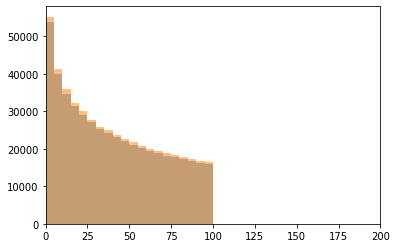

In [13]:
param = 1
dist = train[:,param]*predict[:,0]
plt.hist(x=train[:,param],weights=predict[:,1],alpha=0.5, bins=np.arange(0,1000,5))
plt.hist(x=train[:,param],weights=predict[:,0],alpha=0.5, bins=np.arange(0,1000,5))
plt.xlim(0,200)